<a href="https://colab.research.google.com/github/cl3225/CHAZ/blob/main/CHAZ_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cartopy
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 12.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import xarray as xr
import pandas as pd
import pooch
import scipy.stats as stats

import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [ ]:
path_data ='doi:10.5281/zenodo.12533388'
FileAName = pooch.retrieve(url=f"{path_data}/MRI-ESM2-0_Global_2100_2ens000_CRH_compressed.nc",  known_hash=None)


SHA256 hash of downloaded file: 1594781e03d9446123e42ee58686b39f229b3080ee4c077cab972f6f8d348d50
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


In [ ]:
ds = xr.open_dataset(FileAName)

In [ ]:
time_1d = ds.time.values.reshape(-1)
df_chaz_t = pd.to_datetime(time_1d,unit='D',origin=pd.Timestamp('1950-01-01'))
origional_shape = ds.time.values.shape
df_chaz_t = df_chaz_t.to_numpy().reshape(origional_shape)
ds['time_datetime'] = (('lifelength', 'stormID'), df_chaz_t)

### 1. Time series of TC grequency

<ipython-input-6-5b4e8ac4d239>:1: RuntimeWarning: All-NaN slice encountered
  LMI = np.nanmax(ds['Mwspd'].values,axis=1)


Text(0, 0.5, 'Frequency')

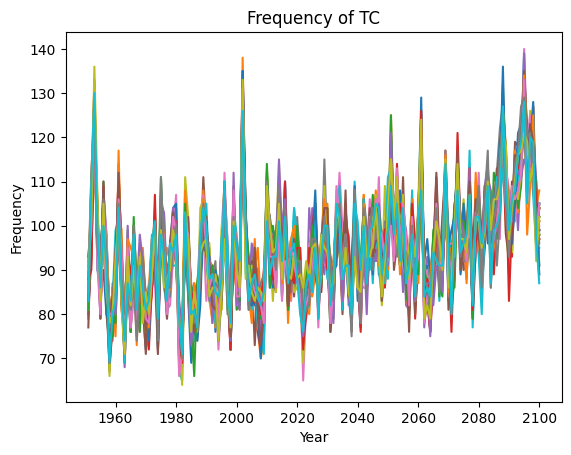

In [ ]:
LMI = np.nanmax(ds['Mwspd'].values,axis=1)
ds_year = np.tile(ds.year.values,(40,1))
freq = np.array([[np.argwhere(LMI[iN, ds.year.values == iy]>34).shape[0] for iy in range(1951, 2100 + 1)] for iN in range(40)])
plt.plot(range(1951, 2100 + 1),freq.T)
plt.title('Frequency of TC')
plt.xlabel('Year')
plt.ylabel('Frequency')


### 2. Track density

In [ ]:
def densityplots(filename,genesis=False):
        dspy = xr.open_dataset(filename)
        figname = 'temp'
        longitude = np.array(dspy['longitude'][:]).ravel()
        latitude = np.array(dspy['latitude'][:]).ravel()
        wspd = np.array(dspy['Mwspd'][:])
        fulllon = np.array([])
        fulllat = np.array([])
        for i in range(len(wspd)):
                winds = wspd[i].ravel()
                df = pd.DataFrame({'lon':longitude, 'lat':latitude,'wspd':winds})
                df = df[df['lon'].notna()]
                df = df[df['lat'].notna()]
                df = df[df['wspd'].notna()]
                lon = np.array(df['lon'])
                lon[lon<=0] = lon[lon<=0]+360
                lat = np.array(df['lat'])
                fulllon = np.hstack([fulllon,lon])
                fulllat = np.hstack([fulllat,lat])
        plt.figure(figsize=(6, 6))
        data_crs = ccrs.PlateCarree()
        ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=180))
        output = stats.binned_statistic_2d(fulllon, fulllat, values = None, statistic='count' , bins = [120, 100])
        plot1 = plt.pcolormesh(output.x_edge,output.y_edge,output.statistic.T,transform = data_crs, cmap='hot_r')


        ax.set_global()
        ax.coastlines()
        ax.gridlines(draw_labels=True)

        cbar = plt.colorbar(plot1,ax=ax, pad = .015, aspect=1)
        filename = figname+'density.png'
        #plt.savefig(uniquify(filename))

        plt.show()

        return()



/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


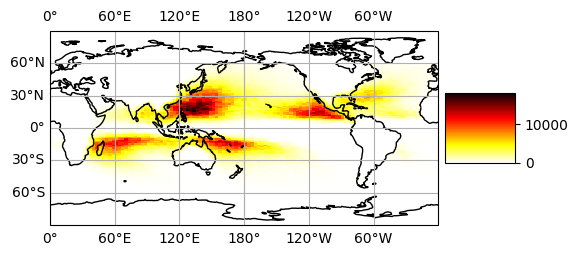

()

In [ ]:
densityplots(FileAName)

### 3. Return period over Japan

In [ ]:
def find_poi_tracks(lon,lat,wspd,lon_poi,lat_poi,radius):
        """
        finding storm numbers that is close to lon_poi, and lat_poi
        with in 'radius'(km)
        """
        er = 6371.0#km
        londis = 2.*np.pi*er*np.cos(1.0*lat/180.*np.pi)/360.
        dx = londis*(lon-lon_poi)
        dy = 110.*(lat-lat_poi)
        distance = np.sqrt(dx*dx+dy*dy)
        distance[wspd!=wspd] = radius+10000
        distance[distance!=distance] = radius+10000
        i_poi = np.argwhere(np.nanmin(distance,axis=0)<=radius)[:,0]
        return i_poi
def find_timing_Tracks(lon,lat,wspd,lon_poi,lat_poi,radius):
        """
        finding storm numbers that is close to lon_poi, and lat_poi
        with in 'radius'(km)
        """
        er = 6371.0#km
        londis = 2*np.pi*er*np.cos(lat/180*np.pi)/360
        dx = londis*(lon-lon_poi)
        dy = 110*(lat-lat_poi)
        distance = np.sqrt(dx*dx+dy*dy)
        distance[wspd!=wspd] = radius+10000
        distance[distance!=distance] = radius+10000
        i_poi = np.argwhere(distance<=radius)[:,0]
        return i_poi
def rescale_matrix(array,scale,axis1):
        """
        rescale matrix through linear-interpolations a
        if it is an 1-d arry, axis1 set to 0
        """
        newax = np.arange(array.shape[axis1]*scale)
        oldax = newax[0::scale]
        f = interpolate.interp1d(oldax,array,axis=axis1,\
                fill_value='extrapolate')
        newarray = f(newax)
        return newarray
def rawPDF_sf(rvs):
        events,bins0 = np.histogram(rvs,\
                np.unique(np.hstack([np.sort(rvs),\
                rvs.max()+5])),density=True) ### you want to have
        events1,bins0 = np.histogram(rvs,\
                np.unique(np.hstack([np.sort(rvs),\
                rvs.max()+5])),density=False) ### you want to have
        binsdiff = bins0[1:]-bins0[0:-1]
        events = events*binsdiff
        sf0 = 1.*np.cumsum(events[::-1])[::-1]
        return bins0,events1,events,sf0

In [ ]:
lon_poi,lat_poi = 139.78,35.5
radius = 300
vmax = np.nanmax(ds['Mwspd'].values,axis=0)

ipoi = find_poi_tracks(ds.longitude.values,ds.latitude.values,\
        vmax,lon_poi,lat_poi,radius)
lon1 = ds.longitude.values[:,ipoi]#rescale_matrix(f.longitude.values[:,ipoi],nscale,0)
lat1 = ds.latitude.values[:,ipoi] #rescale_matrix(f.latitude.values[:,ipoi],nscale,0)

a = []
b = []
c = []
for iN in range(40):
        wspd1 = ds.Mwspd[iN,:,ipoi].values
        #ld.rescale_matrix(f.Mwspd[iN,:,ipoi].values,nscale,0)
        for ii in range(ipoi.shape[0]):
                iipoi = find_timing_Tracks(lon1[:,ii],\
                        lat1[:,ii],\
                        wspd1[:,ii],lon_poi,lat_poi,radius)
                if iipoi.size>0:
                        a.extend([np.nanmax(wspd1[iipoi,ii])])
                        b.extend([ipoi[ii]])
                        c.extend([iN])

a = np.array(a)
b = np.array(b)
c = np.array(c)
d = ds.year[b]

<ipython-input-10-a2177ef46a59>:3: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(ds['Mwspd'].values,axis=0)


Text(0, 0.5, 'intensity (kt)')

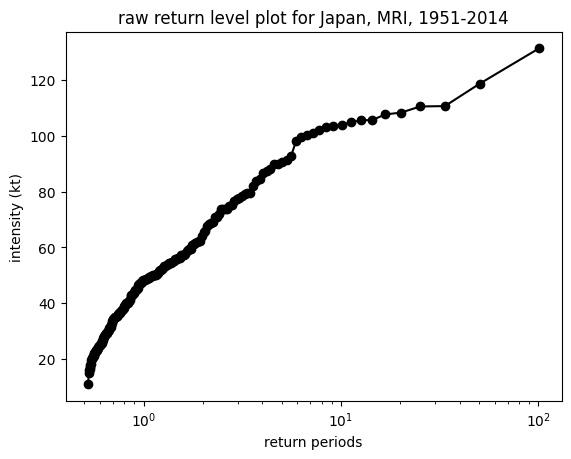

In [ ]:
### raw data's PDF:
bins0,df0,pdf0,sf0 = rawPDF_sf(a[(d<=2014)&(c==0)])
ratio = a[(d<=2014)&(c==0)&(a>=40)].shape[0]/(2014-1951+1) ## to assign a frequency.
plt.figure()
plt.semilogx(1./(sf0*ratio),bins0[:-1],'ko-',zorder=10,label='ori')
plt.title('raw return level plot for Japan, MRI, 1951-2014')
plt.xlabel('return periods')
plt.ylabel('intensity (kt)')
